In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [49]:
pd.set_option('display.max_rows',100)

In [50]:
def peakloadmode(rawdata,percent_batt):
    batt=percent_batt*96
    Consumption_afterPV=[]
    Charge=[]
    for i in rawdata.index:
        if rawdata.loc[i,'Generation']>=rawdata.loc[i,'Consumption']:
            Charge.append(rawdata.loc[i,'Generation']-rawdata.loc[i,'Consumption'])
            Consumption_afterPV.append(0)
        else:
            Charge.append(0)
            Consumption_afterPV.append(rawdata.loc[i,'Consumption']-rawdata.loc[i,'Generation'])    

    rawdata['Charge']=Charge
    rawdata['Consumption_afterPV']=Consumption_afterPV

    totalcharge=rawdata['Charge'].sum()

    data=rawdata

    peakloadtotal=0

    for i in range(1,96):
        peakloaddf=data.nlargest(i,columns='Consumption_afterPV').Consumption_afterPV
        #print(peakloaddf)
        peakload=peakloaddf.iloc[i-1:i]
        peakloadtotal += peakload.iloc[0]
       # print(peakload)
        #print(peakloadtotal)
        if peakloadtotal>=totalcharge:
            remain=(peakloadtotal-totalcharge)
            #print(remain)
            for j in peakloaddf.index:
                data.loc[j:j,'Consumption_afterPV']=0
            data.loc[peakload.index,'Consumption_afterPV']=remain
            break

    data['Discharge']=data.Consumption_afterPV*0
    for i in peakloaddf.index:
        data.loc[i:i,'Discharge']=data.loc[i:i,'Consumption']-data.loc[i:i,'Generation']-data.loc[i:i,'Consumption_afterPV']

    Contactor=[]
    for i in data.index:
        if data.loc[i,'Charge']>0:
            Contactor.append(1)
        elif data.loc[i,'Discharge']>0:
            Contactor.append(1)
        else:
            Contactor.append(0)
    data['Contactor']=Contactor
    data.rename(columns={'Consumption_afterPV':'Consumption_afterDischarge'},inplace=True)
    data['Consumption_afterPV']=data['Consumption_afterDischarge']+data['Discharge']
    return data

In [51]:
def clean1(path):
    rawdata=pd.read_csv(path+".csv", delimiter=";" )
    deleteindex=rawdata.loc[rawdata.loc[pd.IndexSlice[:,'Battery discharging / Mean values [W] ']]==' '].index
    rawdata.drop(deleteindex,inplace=True)
    rawdata.rename(columns={' ':'Time'},inplace=True)
    rawdata['Time']=rawdata['Time'].str.replace('[^\d]','')
    rawdata['Time']=path[15:19]+path[20:22]+path[23:]+rawdata['Time']
    rawdata['Time']=pd.to_datetime(rawdata.Time)
    rawdata.set_index('Time', inplace=True)
    for i in rawdata.columns:
        if i != 'Direct consumption / Mean values [W] ' and i != 'Battery discharging / Mean values [W] ' and i!='External energy supply / Mean values [W] ' and i != 'PV power generation / Mean values [W]  ':
            rawdata.drop([i],axis=1,inplace=True)
    for i in rawdata.columns:
        rawdata[i].fillna('0',inplace=True)
        rawdata[i]=rawdata[i].apply(lambda x: x.replace(' ', '0'))
        rawdata[i]=rawdata[i].str.replace('\D','').astype(int)
    rawdata['Consumption']=rawdata['Direct consumption / Mean values [W] ']+rawdata['Battery discharging / Mean values [W] ']+rawdata['External energy supply / Mean values [W] ']
    rawdata.rename(columns={'PV power generation / Mean values [W]  ':'Generation'},inplace=True)
    rawdata.drop(['Direct consumption / Mean values [W] ', 'Battery discharging / Mean values [W] ','External energy supply / Mean values [W] '],axis=1,inplace=True)
    return rawdata

## Use only month 11

In [52]:
pathlist=[]
for i in range(1,31):
    pathlist.append('Energy_Balance_2018_11_'+str(i).zfill(2))
pathlist

['Energy_Balance_2018_11_01',
 'Energy_Balance_2018_11_02',
 'Energy_Balance_2018_11_03',
 'Energy_Balance_2018_11_04',
 'Energy_Balance_2018_11_05',
 'Energy_Balance_2018_11_06',
 'Energy_Balance_2018_11_07',
 'Energy_Balance_2018_11_08',
 'Energy_Balance_2018_11_09',
 'Energy_Balance_2018_11_10',
 'Energy_Balance_2018_11_11',
 'Energy_Balance_2018_11_12',
 'Energy_Balance_2018_11_13',
 'Energy_Balance_2018_11_14',
 'Energy_Balance_2018_11_15',
 'Energy_Balance_2018_11_16',
 'Energy_Balance_2018_11_17',
 'Energy_Balance_2018_11_18',
 'Energy_Balance_2018_11_19',
 'Energy_Balance_2018_11_20',
 'Energy_Balance_2018_11_21',
 'Energy_Balance_2018_11_22',
 'Energy_Balance_2018_11_23',
 'Energy_Balance_2018_11_24',
 'Energy_Balance_2018_11_25',
 'Energy_Balance_2018_11_26',
 'Energy_Balance_2018_11_27',
 'Energy_Balance_2018_11_28',
 'Energy_Balance_2018_11_29',
 'Energy_Balance_2018_11_30']

In [53]:
rawdata=[]
for i in pathlist:
    df=clean1(i)
    rawdata.append(df)
rawdata

[                     Generation  Consumption
 Time                                        
 2018-11-01 00:15:00           0         1615
 2018-11-01 00:30:00           0         1934
 2018-11-01 00:45:00           0         1655
 2018-11-01 01:00:00           0         1512
 2018-11-01 01:15:00           0         1871
 2018-11-01 01:30:00           0         1563
 2018-11-01 01:45:00           0         1522
 2018-11-01 02:00:00           0         1293
 2018-11-01 02:15:00           0         1685
 2018-11-01 02:30:00           0         1480
 2018-11-01 02:45:00           0         1494
 2018-11-01 03:00:00           0         1402
 2018-11-01 03:15:00           0         1368
 2018-11-01 03:30:00           0         1388
 2018-11-01 03:45:00           0          914
 2018-11-01 04:00:00           0          811
 2018-11-01 04:15:00           0         1302
 2018-11-01 04:30:00           0         1225
 2018-11-01 04:45:00           0         1050
 2018-11-01 05:00:00           0  

In [54]:
for i in range(len(rawdata)):
    rawdata[i]=peakloadmode(rawdata[i],100)
rawdata[0]

,Generation,Consumption,Charge,Consumption_afterDischarge,Discharge,Contactor,Consumption_afterPV
Time,,,,,,,
2018-11-01 00:15:00,0,1615,0,1615,0,0,1615
2018-11-01 00:30:00,0,1934,0,1934,0,0,1934
2018-11-01 00:45:00,0,1655,0,1655,0,0,1655
2018-11-01 01:00:00,0,1512,0,1512,0,0,1512
2018-11-01 01:15:00,0,1871,0,1871,0,0,1871
2018-11-01 01:30:00,0,1563,0,1563,0,0,1563
2018-11-01 01:45:00,0,1522,0,1522,0,0,1522
2018-11-01 02:00:00,0,1293,0,1293,0,0,1293
2018-11-01 02:15:00,0,1685,0,1685,0,0,1685


## Test Graph in 1 day

Text(0, 0.5, 'Watt(W)')

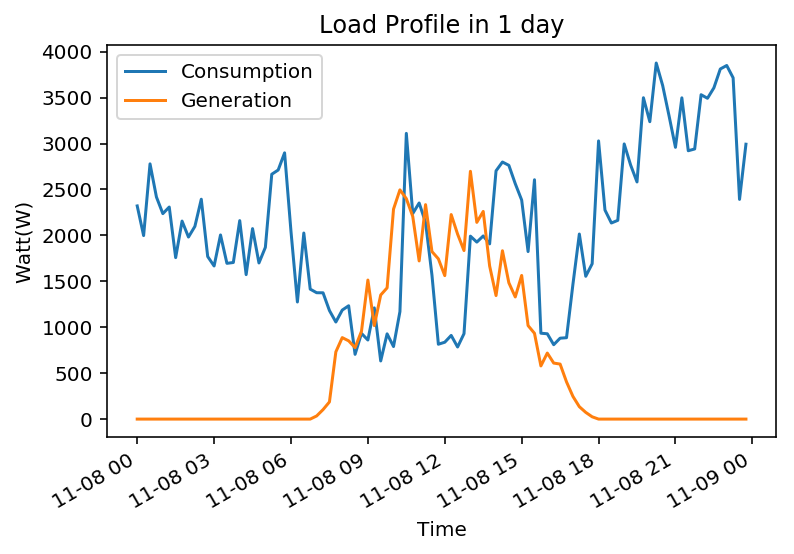

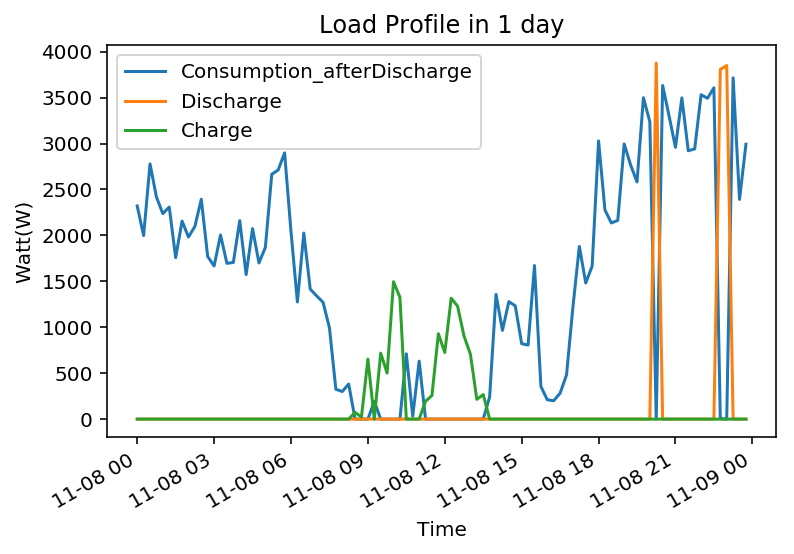

In [55]:
test_day=7  #วันที่ต้องการ -1
rawdata[test_day][['Consumption','Generation']].plot(kind='line',title='Load Profile in 1 day').set_ylabel('Watt(W)')
rawdata[test_day][['Consumption_afterDischarge','Discharge','Charge']].plot(kind='line',title='Load Profile in 1 day').set_ylabel('Watt(W)')

## Test peakload in 1 month

In [65]:
peakbefore=[]
peakafter=[]
for i in range(len(rawdata)):
    peakbefore.append(rawdata[i].nlargest(1,columns='Consumption_afterPV')['Consumption_afterPV'])
    peakafter.append(rawdata[i].nlargest(1,columns='Consumption_afterDischarge')['Consumption_afterDischarge'])

In [66]:
peakbefore

[Time
 2018-11-01 20:30:00    4512
 Name: Consumption_afterPV, dtype: int64, Time
 2018-11-02 22:45:00    4348
 Name: Consumption_afterPV, dtype: int64, Time
 2018-11-03 23:30:00    4132
 Name: Consumption_afterPV, dtype: int64, Time
 2018-11-04 19:30:00    4161
 Name: Consumption_afterPV, dtype: int64, Time
 2018-11-05 19:00:00    4264
 Name: Consumption_afterPV, dtype: int64, Time
 2018-11-06 21:45:00    3868
 Name: Consumption_afterPV, dtype: int64, Time
 2018-11-07 21:00:00    4687
 Name: Consumption_afterPV, dtype: int64, Time
 2018-11-08 20:15:00    3877
 Name: Consumption_afterPV, dtype: int64, Time
 2018-11-09 05:30:00    3935
 Name: Consumption_afterPV, dtype: int64, Time
 2018-11-10 01:45:00    4443
 Name: Consumption_afterPV, dtype: int64, Time
 2018-11-11 21:00:00    3964
 Name: Consumption_afterPV, dtype: int64, Time
 2018-11-12 19:30:00    4300
 Name: Consumption_afterPV, dtype: int64, Time
 2018-11-13 20:45:00    4305
 Name: Consumption_afterPV, dtype: int64, Time
 2018-

In [67]:
peakafter

[Time
 2018-11-01 20:00:00    3086
 Name: Consumption_afterDischarge, dtype: int64, Time
 2018-11-02 20:15:00    3021
 Name: Consumption_afterDischarge, dtype: int64, Time
 2018-11-03 23:45:00    3050
 Name: Consumption_afterDischarge, dtype: int64, Time
 2018-11-04 19:45:00    3312
 Name: Consumption_afterDischarge, dtype: int64, Time
 2018-11-05 19:15:00    3467
 Name: Consumption_afterDischarge, dtype: int64, Time
 2018-11-06 05:45:00    3413
 Name: Consumption_afterDischarge, dtype: int64, Time
 2018-11-07 22:15:00    3692
 Name: Consumption_afterDischarge, dtype: int64, Time
 2018-11-08 23:15:00    3716
 Name: Consumption_afterDischarge, dtype: int64, Time
 2018-11-09 05:30:00    3543
 Name: Consumption_afterDischarge, dtype: int64, Time
 2018-11-10 22:15:00    4106
 Name: Consumption_afterDischarge, dtype: int64, Time
 2018-11-11 19:30:00    3761
 Name: Consumption_afterDischarge, dtype: int64, Time
 2018-11-12 22:00:00    3430
 Name: Consumption_afterDischarge, dtype: int64, Tim